# Pre-requisits
- python=3.8.3
- numpy=1.19.2
- scikit-learn=0.23.1
- scikit-optimize=0.8.1

# Whats the Problem?
- Some unknonw function f(x).
- We can sample f at arbitrary points but this evaluation is expensive. 
- The samples we obtain might be noisy
- We have no analytical information especially not about gradients
- we assume f is Lipschitz-continous --> || f(x1) - f(x2) || <= C||x1-x2||
- we assume the search space is bound.
- That would leave us with (C/2e)^d samples we need to obtain before being certain of f(x') >= f(x)-e, given our space is a d-dimensional cube.

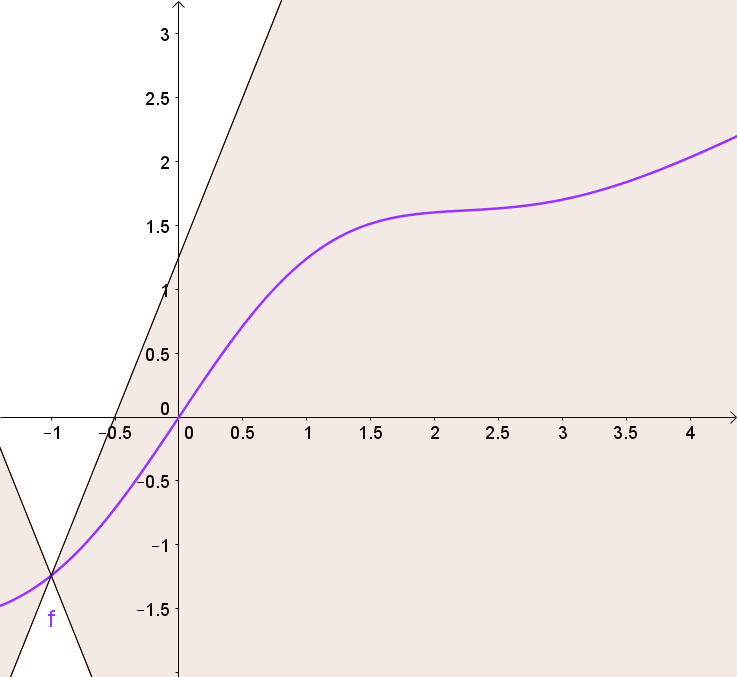

# Solutions
- random\grid search
- coordinate search
- nelder-mead
- covariance-matrix adaptation
- bayesian optimization

# Kernels

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from matplotlib.ticker import FormatStrFormatter

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 5))
mu = 0.5
variance = 0.01
sigma = math.sqrt(variance)
x = np.linspace(mu - 2*sigma, mu + 3*sigma, 500)
prior = stats.norm.pdf(x, mu, 0.02)
data = stats.norm.pdf(x, 0.7, 0.05)
posterior = prior*data
posterior =  ((prior.sum() + data.sum()) / 2.0) * (posterior.astype(float) / posterior.astype(float).sum())
ax1.plot(x, prior , linestyle='dotted', label='prior')
ax1.plot(x, data , linestyle='--', label='data')
ax1.plot(x, posterior, label='posterior')
ax1.legend(fontsize=16)
ax1.set_title('strong prior information', fontsize=20)
ax1.set_yticks([])
ax1.set_xticks([0.5, 0.7])
ax1.axvline( x[np.argmax(posterior)], color='red')
ax1.set_xticks([0.5, x[np.argmax(posterior)], 0.7])

prior = stats.norm.pdf(x, mu, 0.1)
data = stats.norm.pdf(x, 0.7, 0.05)
posterior = prior*data
posterior =  ((prior.sum() + data.sum()) / 2.0) * (posterior.astype(float) / posterior.astype(float).sum())
ax2.plot(x, prior , linestyle='dotted', label='prior')
ax2.plot(x, data , linestyle='--', label='data')
ax2.plot(x, posterior, label='posterior')
ax2.legend(fontsize=16)
ax2.set_title('weak prior information', fontsize=20)
ax2.set_yticks([])
ax2.axvline( x[np.argmax(posterior)], color='red')
ax2.set_xticks([0.5, x[np.argmax(posterior)], 0.7])

ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax1.set_ylabel('Probability', fontsize=16)
fig.supxlabel(r'$\theta$')



plt.savefig(IMG_PATH+'PDF_PRIOR_AND_DATA_TO_POSTERIOR.png', dpi=300)

plt.show()

# Simple One-liner api
- gp_minimize
- forrest_minimize

In [2]:
# IMPORTS
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt
import time

In [3]:
# PLOTTING PARAMS
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['font.size'] = 15
plt.rc('legend', fontsize=16)

In [4]:
#### NOISY OBJECTIVE FUNCTIONS
noise_level = 0.02

####### RUGGED ########
def rugged_objective(x, noise=noise_level):
    x = x[0]
    if x <= 3.2:
        return 4-x + np.random.randn()*noise
    if x > 3.2 and x <= 4:
        return 3.5 + np.random.randn()*noise
    if x > 4 and x <5:
        return 4.7 + np.random.randn()*noise
    else:
        return 1.5 + np.random.randn()*noise
    
def rugged_wo_noise(x):
    return rugged_objective(x, noise=0)


########### SMOOTH #############
def smooth_objective(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh((x[0]-3) ** 2))\
           + np.random.randn() * noise_level

def smooth_wo_noise(x):
    return smooth_objective(x, noise_level=0)

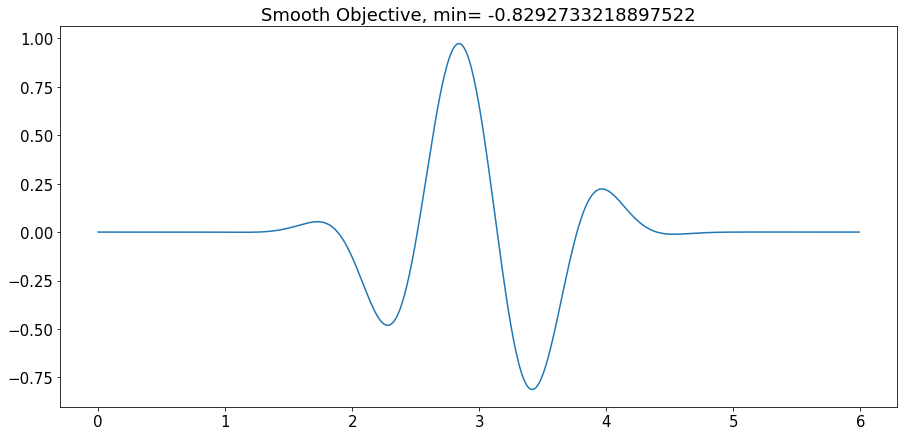

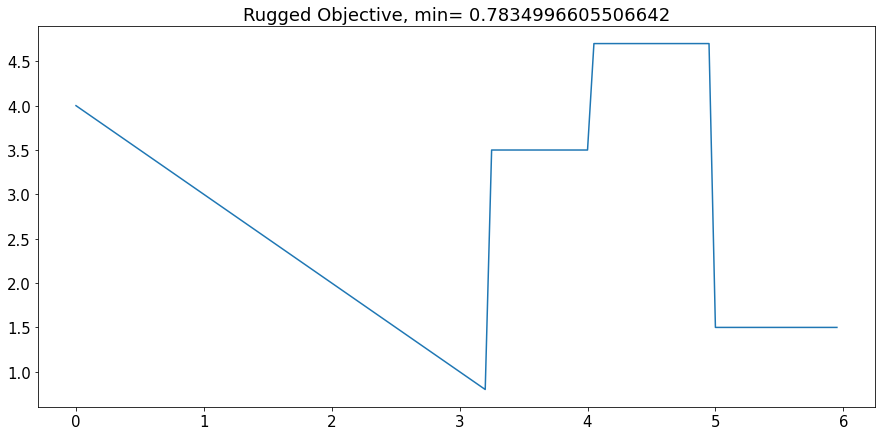

In [105]:
ax = plt.plot(np.arange(0,6,0.01), [smooth_wo_noise([x]) for x in np.arange(0,6,0.01)] )
mini = min([smooth_objective([x]) for x in np.arange(0,6,0.01)])
plt.title('Smooth Objective, min= '+str(mini))
plt.show()
ax = plt.plot(np.arange(0,6,0.05), [rugged_wo_noise([x]) for x in np.arange(0,6,0.05)] )
mini = min([rugged_objective([x]) for x in np.arange(0,6,0.05)])
plt.title('Rugged Objective, min= '+str(mini))
plt.show()


In [5]:
#### RUGGED OPBJECTIVE 
dummy_res = []
gp_res = []
forest_res = []

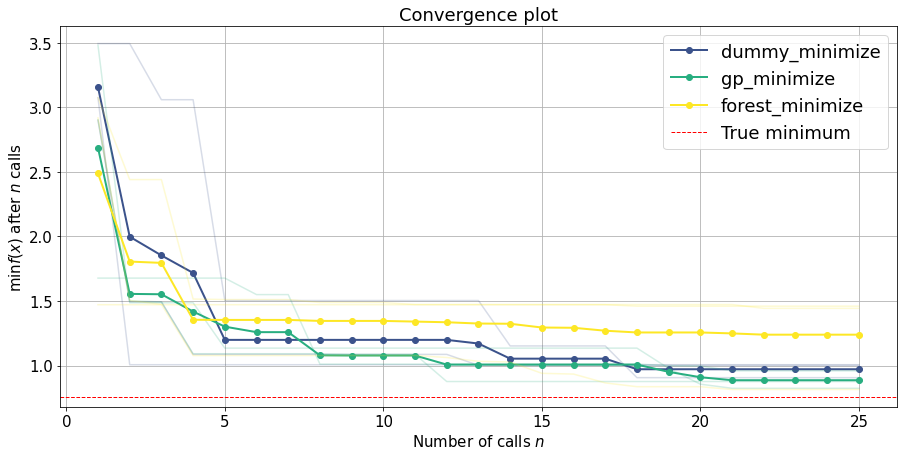

In [10]:
from skopt import dummy_minimize, gp_minimize, forest_minimize
from skopt.plots import plot_gaussian_process, plot_convergence
from warnings import simplefilter
simplefilter('ignore')

n_calls=25
acq_func = 'LCB'
space=(0.0,6.0)
objective=rugged_objective
objective_wo_noise= rugged_wo_noise

# One liner optimization Calls
dummy_res.append(dummy_minimize(func=objective, dimensions=[space], n_calls=n_calls))
gp_res.append(gp_minimize(func=objective, acq_func=acq_func,dimensions=[space], n_calls=n_calls))
forest_res.append(forest_minimize(func=objective, acq_func=acq_func, dimensions=[space], n_calls=n_calls))

# Plot Results
plot = plot_convergence(("dummy_minimize", dummy_res),
                        ("gp_minimize", gp_res),
                        ("forest_minimize", forest_res),
                        true_minimum=0.76)

plot.legend(loc="best", prop={'size': 18}, numpoints=1)

<AxesSubplot:title={'center':'x* = 3.1479, f(x*) = 0.8145'}, xlabel='x', ylabel='f(x)'>

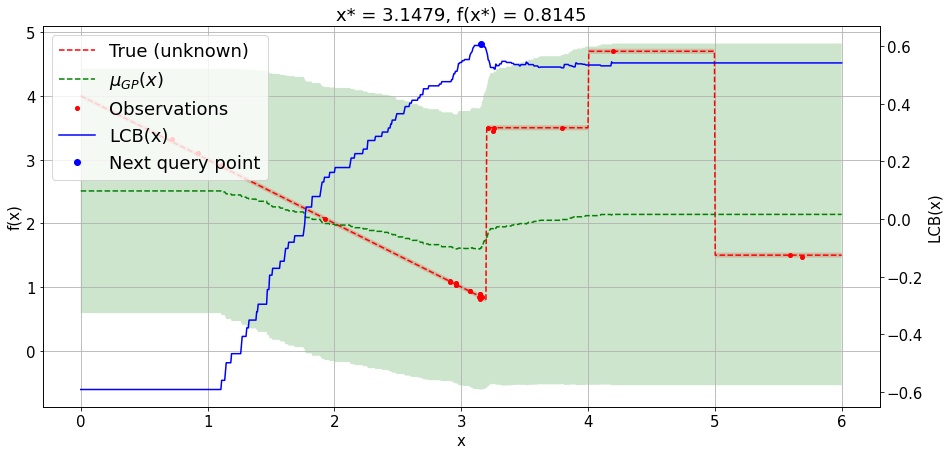

In [8]:
plot_gaussian_process(forest_res[0],
                       objective=objective_wo_noise,
                       noise_level=noise_level,
                       show_legend=True, show_title=True,
                       show_next_point=True, show_acq_func=True, show_mu=True)

<AxesSubplot:title={'center':'x* = 3.4325, f(x*) = -0.8366'}, xlabel='x', ylabel='f(x)'>

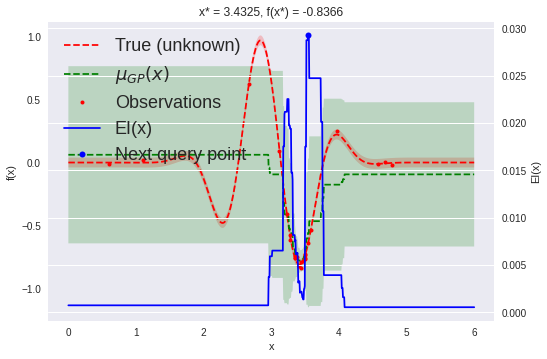

In [34]:
from IPython import display
import time
from skopt import Optimizer
fig, ax = plt.subplots()
fig.suptitle("Standard GP kernel")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.legend(fontsize=20) 

# Config
objective=smooth_objective
objective_wo_noise= smooth_wo_noise
explore = 0.1
exploit = 0.001
estimator = 'RF'

# instantiate Optimizer
opti = Optimizer([space], 
                   base_estimator=estimator,
                   n_initial_points=5,
                   acq_optimizer="sampling",
                   random_state=42,
                   acq_func='gp_hedge',
                   acq_func_kwargs={"xi": exploit, "kappa": 5})

# Ask and Tell interface
for i in range(5):
    next_x = opti.ask()
    f_val = objective(next_x)
    opti.tell(next_x, f_val)

for i in range(20):
    next_x = opti.ask()
    f_val = objective(next_x)
    opti.tell(next_x, f_val)
    display.clear_output()
    display.display(
            plot_gaussian_process(opti.get_result(),
                   objective=objective_wo_noise,
                   noise_level=noise_level,
                   show_legend=True, show_title=True,
                   show_next_point=True, show_acq_func=True, show_mu=True)
    )
    plt.show()
    time.sleep(2)


In [63]:
def plot_optimizer(res, n_iter, max_iters=5):
    ax = plt.subplot(max_iters, 1, 1 * n_iter + 1)

    if n_iter == 0:
        show_legend = True
        
    else:
        show_legend = False
    # Plot GP(x) + contours
    ax = plot_gaussian_process(res, ax=ax,
                               objective=objective_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=True,
                               show_next_point=True, show_acq_func=True)
    
            
    ax.set_ylabel("")
    ax.set_xlabel("")
    
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])


## Hyperparameter Tuning

In [2]:
## DATA ##
from sklearn import datasets
from sklearn.model_selection import train_test_split
x, y = datasets.make_classification(n_samples=200, n_features=8)
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True
)
print(X_train.shape, y_train.shape)

(160, 8) (160,)


In [26]:
# MODEL 
from sklearn.neural_network import MLPRegressor as MLP

def create_model(n1, n2, n3, a):
    clf = MLP(hidden_layer_sizes=(n1, n2, n3), alpha=a, random_state=42, max_iter=1000, solver='adam')
    return clf

In [27]:
# OBJECTIVE
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
def objective(args):
    #print(args)
    model: MLP = create_model(*args)
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, y_train)
    #pred_y = pipe.predict(X_test)
    score = pipe.score(X_test, y_test)
    #print(score, pred_y, y_test)
    return -score

    

In [28]:
# OPTIMIZATION
from skopt.space import Categorical, Real, Integer
from skopt import Optimizer

n1 = Integer(low=8, high=32, name='neurons1')
n2 = Integer(low=8, high=32, name='neurons2')
n3 = Integer(low=8, high=32, name='neurons3')
a = Real(low=0.000001, high=0.01, name='alpha')
space=[n1, n2, n3, a]

iters = 50
results = {}
for estimator in ['dummy', 'RF', 'GP']:
    opti = Optimizer(space, 
                       base_estimator=estimator,
                       n_initial_points=10,
                       initial_point_generator='random',
                       acq_optimizer="sampling",
                       random_state=42,
                       acq_func='PI',
                    acq_func_kwargs={"xi": 0.01, "kappa":1.69})
    for i in range(iters):
        x = opti.ask()
        y = objective(x)
        #print(x, y)
        opti.tell(x,y)
    results.update({estimator: opti.get_result()})


/home/iwe7/anaconda3/envs/scfxn/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/iwe7/anaconda3/envs/scfxn/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/iwe7/anaconda3/envs/scfxn/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs fa

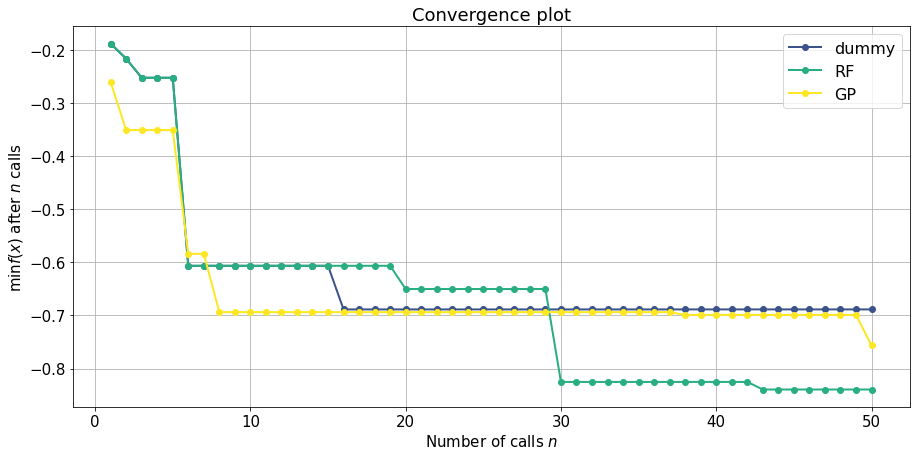

In [109]:
# Results
from skopt.plots import plot_convergence, plot_evaluations, plot_gaussian_process
ax = plot_convergence(*results.values())
ax.legend(['dummy', 'RF', 'GP'])

[20, 8, 19, 0.007394137762318033]


array([[<AxesSubplot:xlabel='neurons1', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='neurons2'>,
        <AxesSubplot:xlabel='neurons2', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='neurons3'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='neurons3', ylabel='Number of samples'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='neurons1', ylabel='alpha'>,
        <AxesSubplot:xlabel='neurons2'>, <AxesSubplot:xlabel='neurons3'>,
        <AxesSubplot:xlabel='alpha', ylabel='Number of samples'>]],
      dtype=object)

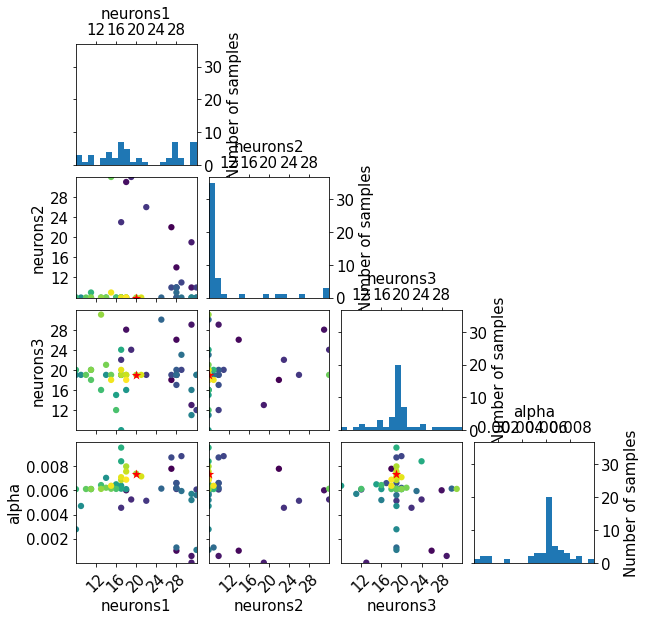

In [120]:
print(results['RF'].x)
plot_evaluations(results['RF'])

[11, 9, 13, 0.0020802086870190207]


array([[<AxesSubplot:xlabel='neurons1', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='neurons2'>,
        <AxesSubplot:xlabel='neurons2', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='neurons3'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='neurons3', ylabel='Number of samples'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='neurons1', ylabel='alpha'>,
        <AxesSubplot:xlabel='neurons2'>, <AxesSubplot:xlabel='neurons3'>,
        <AxesSubplot:xlabel='alpha', ylabel='Number of samples'>]],
      dtype=object)

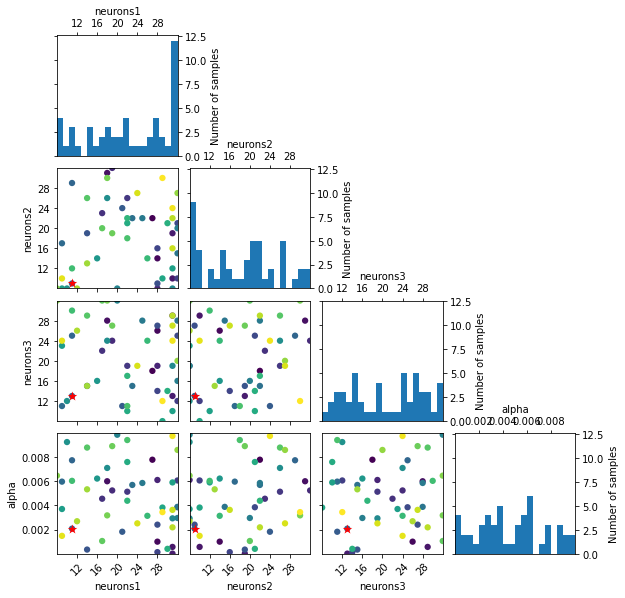

In [32]:
print(results['dummy'].x)
plot_evaluations(results['dummy'])
#plot_gaussian_process(results['dummy'])

[19, 29, 27, 0.0017433584356554121]


array([[<AxesSubplot:xlabel='neurons1', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='neurons2'>,
        <AxesSubplot:xlabel='neurons2', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='neurons3'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='neurons3', ylabel='Number of samples'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='neurons1', ylabel='alpha'>,
        <AxesSubplot:xlabel='neurons2'>, <AxesSubplot:xlabel='neurons3'>,
        <AxesSubplot:xlabel='alpha', ylabel='Number of samples'>]],
      dtype=object)

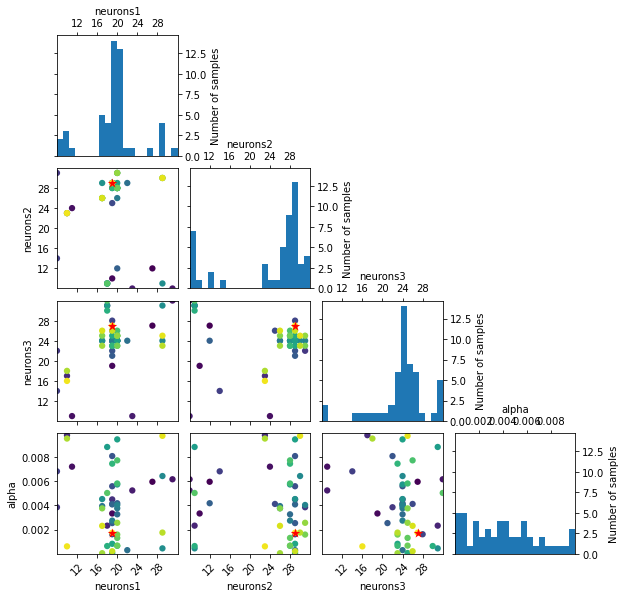

In [33]:
print(results['GP'].x)
plot_evaluations(results['GP'])
#plot_gaussian_process(results['GP'])

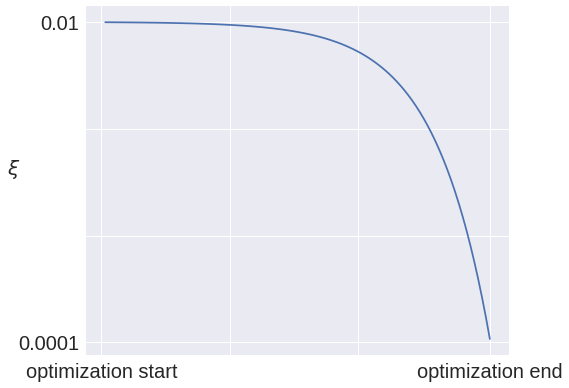

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
evals =100
xi =1
final_xi = 0.01
kappa=10
final_kappa = 2
# LOOKUP TABLE FOR COOLDOWN
xi_kappa_lookup = pd.DataFrame(None, index=range(1, evals+1))
xi_kappa_lookup["iter"] = range(1, evals+1)
xi_kappa_lookup["geospace"] = np.geomspace(
    0.001, 1, num=evals)
xi_kappa_lookup["xi"] = xi - \
    xi_kappa_lookup.geospace * (xi - final_xi)
xi_kappa_lookup["kappa"] = kappa - \
    xi_kappa_lookup.geospace * \
    (kappa - final_kappa)
#pd.options.plotting.backend = "matplotlib"
plt.style.use('seaborn')
xi_kappa_lookup.xi.plot(fontsize=20)
plt.ylabel(r'$\xi$', fontsize=20, rotation=0)
plt.yticks([0,0.33, 0.666 ,1],['0.0001',"","", '0.01'])
plt.xticks([0, 33, 66, 100],['optimization start',"","", 'optimization end'])
plt.tight_layout()
plt.savefig("../Documents/master_thesis/imgs/SCALE_EXPLORE_EXPLOIT.png", dpi=300)

# Gaussian Processes

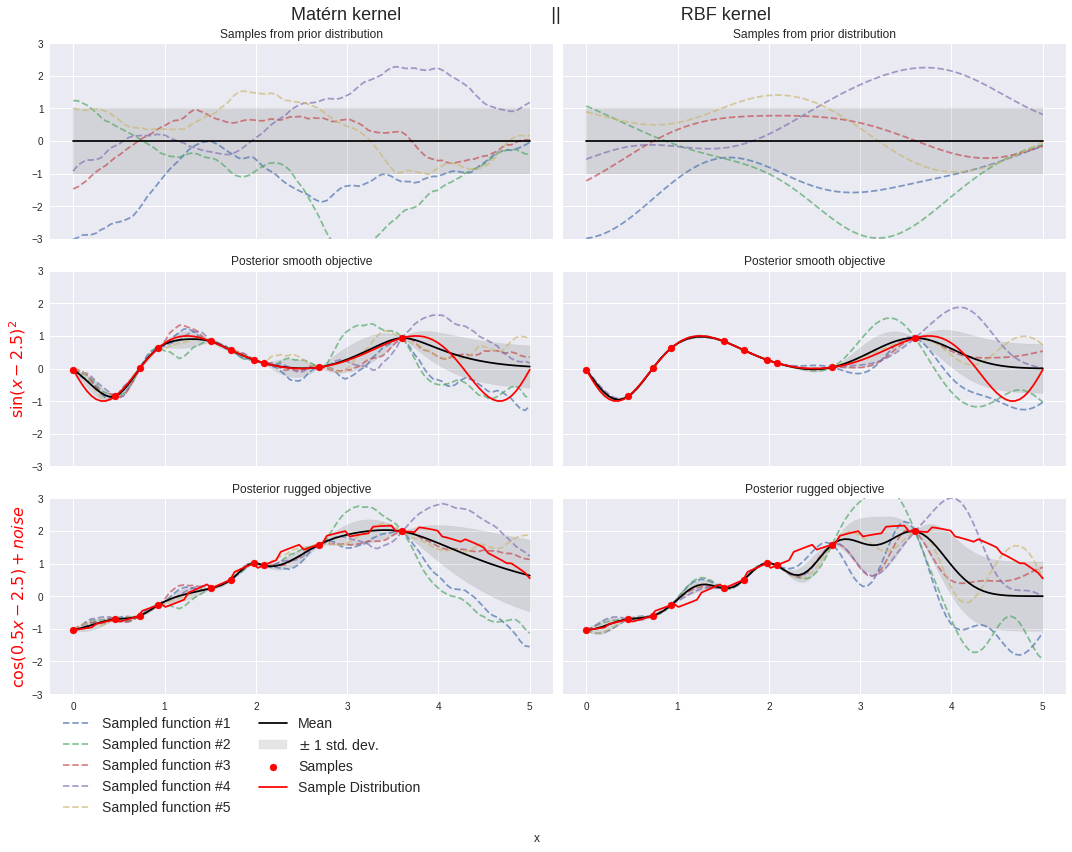

In [12]:
import matplotlib.pyplot as plt
import numpy as np


def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 5, 100)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_ylim([-3, 3])
### Rugged OBJECTIVE KERNELS ###########
from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib import pyplot as plt
fig, axs = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(15, 12))
def rugged(v_in):
    return np.array([x + 0.1 if x%0.5 >= 0.25 else x-0.1 for x in v_in]).reshape(-1,)
    #return (v_in % 0.5).reshape(-1, )
rng = np.random.RandomState(1)
X_train = rng.uniform(0, 5, 10).reshape(-1, 1)
y_train = np.sin((X_train[:, 0] - 2.5) ** 2)
x = np.linspace(0,5,100).reshape(-1, 1)
true_objective = np.sin((x[:,0] - 2.5) **2)
n_samples = 5

    
# MATERN############
kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
gprM = GaussianProcessRegressor(kernel=kernel, random_state=rng)
# plot prior
plot_gpr_samples(gprM, n_samples=n_samples, ax=axs[0][0])
axs[0][0].set_title("Samples from prior distribution")

# plot posterior smooth
gprM.fit(X_train, y_train)
plot_gpr_samples(gprM, n_samples=n_samples, ax=axs[1][0])
axs[1][0].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Samples")
axs[1][0].plot(x, true_objective, color='red', label='Sample Distribution')
axs[1][0].set_title("Posterior smooth objective")
axs[1][0].set_ylabel(r"$\sin(x-2.5)^2$", fontsize=16, color='red')

#axs[1][0].legend(bbox_to_anchor=(0.0, -0.05), loc="upper left", fontsize=14, ncol=2)


# plot posterior rugged
#### RUGGGED
#X_train = rng.uniform(0, 5, 10).reshape(-1, 1)
y_train = np.cos(0.5*(X_train[:, 0] - 2.5))*rugged(X_train)-1
x = np.linspace(0,5,100).reshape(-1, 1)
true_objective = np.cos(0.5*(x[:, 0] - 2.5))*rugged(x)-1
kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
gprM = GaussianProcessRegressor(kernel=kernel, random_state=rng)
gprM.fit(X_train, y_train)
plot_gpr_samples(gprM, n_samples=n_samples, ax=axs[2][0])
axs[2][0].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Samples")
axs[2][0].plot(x, true_objective, color='red', label='Sample Distribution')
axs[2][0].set_title("Posterior rugged objective")
axs[2][0].legend(bbox_to_anchor=(0.0, -0.05), loc="upper left", fontsize=14, ncol=2)
axs[2][0].set_ylabel(r"$\cos(0.5x-2.5) + noise$", fontsize=16, color='red')


#################

# RBF##############
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gprR = GaussianProcessRegressor(kernel=kernel, random_state=rng)

# plot prior
plot_gpr_samples(gprR, n_samples=n_samples, ax=axs[0][1])
axs[0][1].set_title("Samples from prior distribution")

# plot posterior rugged
gprR.fit(X_train, y_train)
plot_gpr_samples(gprR, n_samples=n_samples, ax=axs[2][1])
axs[2][1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Samples")
axs[2][1].plot(x, true_objective, color='red', label='Sample Distribution')
axs[2][1].set_title("Posterior rugged objective")

# plot posterior smooth
#X_train = rng.uniform(0, 5, 10).reshape(-1, 1)
y_train = np.sin((X_train[:, 0] - 2.5) ** 2)
x = np.linspace(0,5,100).reshape(-1, 1)
true_objective = np.sin((x[:,0] - 2.5) **2)

gprR.fit(X_train, y_train)
plot_gpr_samples(gprR, n_samples=n_samples, ax=axs[1][1])
axs[1][1].scatter(X_train[:, 0], y_train, color="red", zorder=10, label="Samples")
axs[1][1].plot(x, true_objective, color='red', label='Sample Distribution')
axs[1][1].set_title("Posterior smooth objective")

###################
fig.suptitle("                  Matérn kernel                              ||                        RBF kernel                    ", fontsize=18)
fig.supxlabel('x')
plt.tight_layout()
#plt.savefig(IMG_PATH+"KERNELS_COMPARE_OBJECTIVE.png", dpi=300)